In [1]:
import pandas as pd
# pd.options.mode.chained_assignment = None  # default='warn'
import ast as ast
import numpy as np
from typing import *

from task_2_helpers import *
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers
from tensorflow.keras import Sequential

import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import re

import datasets
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from textblob import TextBlob
from collections import defaultdict

import matplotlib.pyplot as plt

# from task2_business_KNN import classify_Kmeans


/home/kidou/Documents/UNIGE/ml_reinforcement/Projects/customer/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-05-20 14:56:52.550284: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 14:56:52.587790: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-20 14:56:52.588767: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 14:56:53.415008: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find

Milestone 

In [2]:
df_data_res = pd.read_parquet('data/ATML2024_Task2_PhiliResRatings.parquet', engine='pyarrow')
print(df_data_res.shape)

(123414, 12)


In [8]:
# df_res_short = df_data_res[df_data_res['tokens_count'] < 256]

It is possible to reduce the size of the too big reviews using a text2text pretrained model. 
Exemple bellow uses pytorch

In [9]:
"""Generate smaller text from bigger text using transformer tokenizer"""

try: 
    import torch 
    
    model_name = "allenai/led-large-16384-arxiv"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
    
    pipe = pipeline("text2text-generation", model=model, tokenizer=tokenizer, device=0)

    # apply below function to all reviews 
    def generate_smaller_text(text : str, length : int = 64) -> str:
        generated_text = pipe(
            text, 
            truncation=True, 
            max_length=length, 
            no_repeat_ngram_size=5, 
            num_beams=3, 
            early_stopping=True
        )

except ImportError as e:
    print("Error : {}".format(e))
    

Error : No module named 'torch'


#### 2.4 Sentiment Analysis

In [10]:
# Function to calculate sentiment score from pretrained models
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [11]:
# Calculate sentiment for each review
df_data_res['sentiment'] = df_data_res['text'].apply(get_sentiment)

In [97]:
# Initialize dictionaries to store ratings and sentiments for each attribute
attribute_ratings = defaultdict(list)
attribute_sentiments = defaultdict(list)

# Populate the dictionaries
for index, row in df_data_res.iterrows():
    for attribute in row['attributes_list']:
        attribute_ratings[attribute].append(row['rating'])
        attribute_sentiments[attribute].append(row['sentiment'])

# Remove the last quantile of sentiments and 
n_cut = 10
attribute_ratings_sub = dict(sorted(attribute_ratings.items(), key=lambda x:len(x[1]), reverse=True)[:n_cut])
attribute_sentiments_sub = dict(sorted(attribute_sentiments.items(), key=lambda x:len(x[1]), reverse=True)[:n_cut])

# Calculate the mean rating and mean sentiment for each attribute
attribute_mean_ratings_sub = {attr: sum(ratings) / len(ratings) for attr, ratings in attribute_ratings_sub.items()}
attribute_mean_sentiments_sub = {attr: sum(sentiments) / len(sentiments) for attr, sentiments in attribute_sentiments_sub.items()}

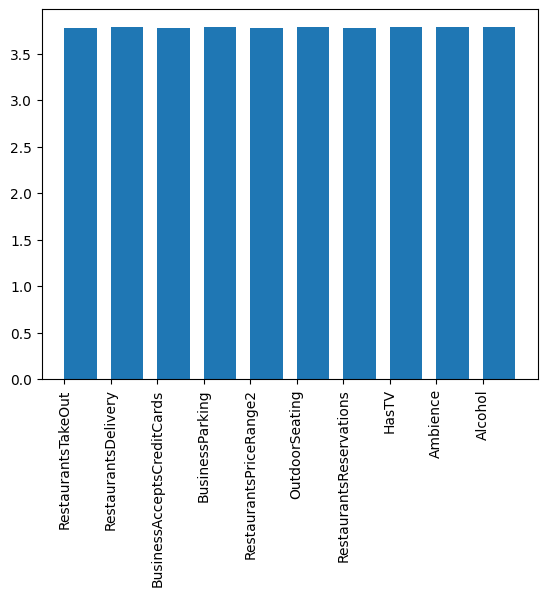

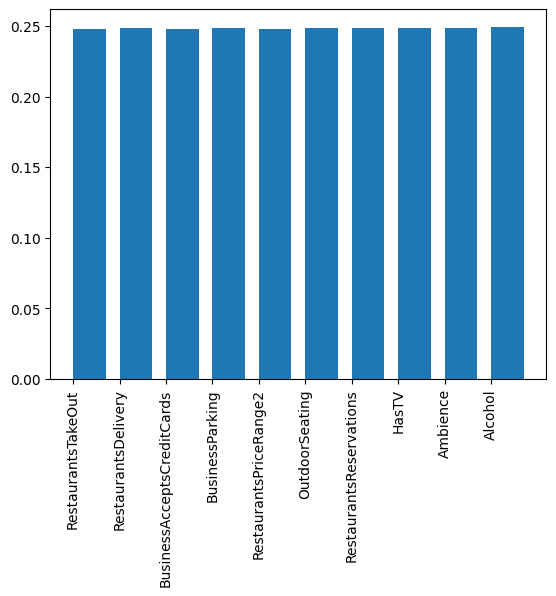

In [99]:
# Box plot 
plt.bar(range(1, len(attribute_mean_ratings_sub) + 1), list(attribute_mean_ratings_sub.values()),  align='edge', width=0.7)
plt.xticks(range(1, len(attribute_mean_ratings_sub) + 1), attribute_mean_ratings_sub.keys(),rotation=90)
plt.show()

plt.bar(range(1, len(attribute_mean_sentiments_sub ) + 1), list(attribute_mean_sentiments_sub.values()),  align='edge', width=0.7)
plt.xticks(range(1, len(attribute_mean_sentiments_sub ) + 1), attribute_mean_sentiments_sub .keys(),rotation=90)
plt.show()

#### 2.5 Aspect based sentiment Analysis 

In this section we perform a so-called Aspect-Based Sentiment Analysis.
The idea is to give a sentiment to a review based on a list of predifined aspect. For example in the sentence : <br>
"The food was great in a clean place. However the service was terrible."<br>
We would like to extract a positive sentiment for food and a negative sentiment for service.
Aspects are manually selected. We choose to expose the results using the aspects : "food" and "service".

In [3]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /home/kidou/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/kidou/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/kidou/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

Extensive list of words related to another word or theme can be find in NLP libraires such as nltk. For the sake of simplicity we use a predefined list.

In [4]:
# Predefined aspects and their related keywords
aspects_keywords = {
    "food": ["food", "dish", "meal", "taste", "flavor"],
    "service": ["service", "staff", "waiter", "waitress"]
}

First we split the review in n reviews (n being the number of aspects. For example food and service). Notice some parts of the reviews can overlap. It is not a problem. <br>
This is done with the util function `extract_aspect_sentences(review, aspects_keywords)`. It first divides the review in sentences. This is simalar to tokenization, but where the tokens are sentences. The word of the sentence are lemnatized. Finally, for each of those sentences, if one of the aspect keyword appears, the sentence is extracted and appended to a sub-review of that aspect. This is done for all the aspects giving us a dictionary of aspect :: sub-review.

In [5]:
# Example usage
review = "The food was great in a clean place. However the service was terrible."
aspect_sentences = extract_aspect_sentences(review, aspects_keywords)
print(aspect_sentences)

{'food': ['The food was great in a clean place.'], 'service': ['However the service was terrible.']}


We use a pretrained model blob from TextBlob librairy (similar to nltk) to pereform sentiment analysis. This is done on each of the sub-reviews linked to an aspect. <br><br>For better performence of the sentiment analysis an other option would have been to use transormers for example.

In [6]:
# Example usage
reviews = ["The food was great in a clean place. However the service was terrible.",
           "Nice food. Clean place ! "]
aspect_sentiments = [analyze_aspects(review, aspects_keywords) for review in reviews]
print(aspect_sentiments)

[{'food': 'positive', 'service': 'negative'}, {'food': 'positive', 'service': 'neutral'}]


The piece of code below is performing the aspect-based sentiment analysis on each all the reviews and appends the sentiments to the dataframe. 

In [8]:
score = {}
for key in aspects_keywords:
    score[key] = []

# Iterate all reviews in ['text'] column of the DataFrame
for index, row in df_data_res.iterrows():
    aspect_score = analyze_aspects(row['text'], aspects_keywords)
    for key in aspects_keywords:
        score[key].append(aspect_score[key])

# Append to the right of the dataframe
df_aspect_score = pd.DataFrame(score)
if not bool([ii for ii in list(aspects_keywords.keys()) if ii in df_data_res.columns]):
    df_data_res = pd.merge(df_data_res, df_aspect_score, left_index=True, right_index=True)

In [80]:
sentiment_count = {}
sentiment_ratio  = {}
sentiment_ratio_all = {}
for key in score:
    sentiment_count[key] = Counter(score[key])
    sentiment_count[key] = dict(sorted(sentiment_count[key].items()))
    sentiment_ratio[key] = sentiment_count[key]['positive'] / ( sentiment_count[key]['positive'] + \
                                                               sentiment_count[key]['negative'])
    sentiment_ratio_all[key] = sentiment_count[key]['positive'] / \
                             ( sentiment_count[key]['positive'] + sentiment_count[key]['negative'] + \
                               sentiment_count[key]['neutral'] )

In [83]:
sentiment_ratio

{'food': 0.8747465614554222, 'service': 0.8564924079450281}

Plot the sentiment count 

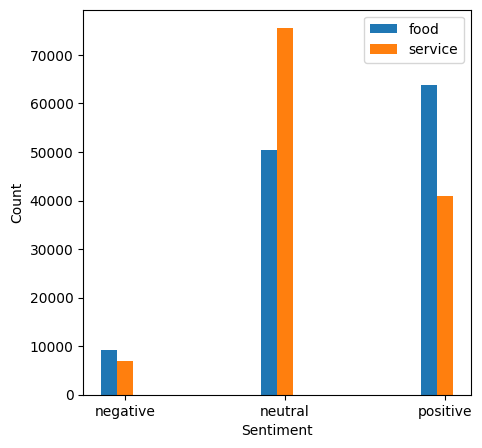

In [96]:
plt.figure(figsize=(5,5))
shift = 0
for key in score:
    names  = list(sentiment_count[key].keys())
    values = list(sentiment_count[key].values())
    plt.bar(np.arange(len(sentiment_count[key]))+shift, values, tick_label=names, width=0.1, label=key)
    shift += 0.1
    plt.ylabel('Count')
    plt.xlabel('Sentiment')
    plt.legend(loc='best')
plt.show()

More than half of the review are without sentiment. This is probably caused by the way of selecting the aspect. 

One can also look at the ratio of positive to negatif sentiments 

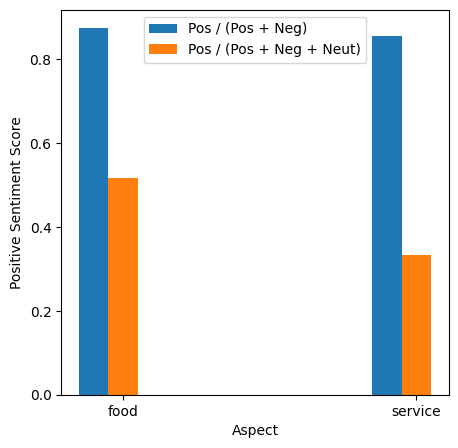

In [100]:
plt.figure(figsize=(5,5))

aspect = list(sentiment_ratio.keys())

plt.bar(np.arange(len(aspect)), list(sentiment_ratio.values()), tick_label=aspect, width=0.1, label='Pos / (Pos + Neg)')
plt.bar(np.arange(len(aspect))+0.1, list(sentiment_ratio_all.values()), tick_label=aspect, width=0.1, label='Pos / (Pos + Neg + Neut)')
plt.xlabel('Aspect')
plt.ylabel('Positive Sentiment Score')
plt.legend(loc='upper center')
plt.show()